# Implémentation de l’Architecture GPT-2 avec NumPy

## Construction d’un modèle de langage auto-régressif (décodeur-uniquement)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Part I : Empécher de Voir le Futur: Le Masque Causal

##Problem 1: Implémentation du Masque Causal

###a) Créez une fonction Python create_causal_mask(seq_len)

In [ ]:
def create_causal_mask(seq_len):
  #b) retourne une matrice de taille (seq_len, seq_len)
  #c) retourne 1 pour le triangle en dessous de la diagonale et 0 pour le triangle au dessus
  #d) Astuce fonction np.tril()
  return np.tril(np.ones((seq_len, seq_len)))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] 



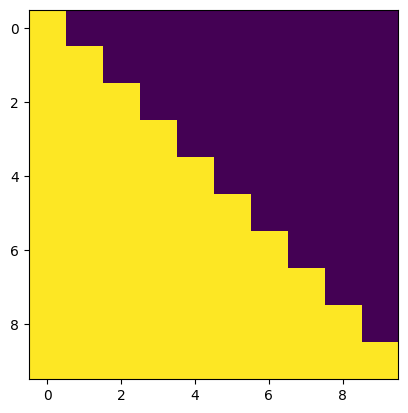

In [ ]:
#e) Visualisation
mask = create_causal_mask(10)
print(mask,'\n')

plt.imshow(mask)
plt.show()

#Part II La Brique Fondamentale: Le Bloc Décodeur de GPT

##Problem 2: Construction du Bloc Décodeur

##a) Réutilisation : classes MultiHeadAttention, FeedForward, et LayerNorm du TP 2

- Pour MultiHeadAttention, la seule adaptation se fera dans la mani`ere
dont nous l’appelons (en lui passant syst´ematiquement un masque causal).

In [ ]:
def  scaled_dot_product_attention(Q, K, V,mask=None):
  # b) calcul des score
  score = Q @ K.swapaxes(-2, -1)

  #c) mise à l'échelle
  scaled_score = score/np.sqrt(Q.shape[-1])
  ## elle permet de garder une variance de 1 et de ne pas saturer le softmax.

  #d) Masquag
  if mask is not None:
    scaled_score = np.where(mask, scaled_score, -1e9)

  #e) Softmax
  exp_score = np.exp(scaled_score - np.max(scaled_score, axis=-1, keepdims=True))
  attention_weights = exp_score / np.sum(exp_score, axis=-1, keepdims=True)

  #f) sortie
  Z = attention_weights @ V

  #g) la fonction retourne Z et attention_qeights
  return Z , attention_weights

In [ ]:
class MultiHeadAttention():

  #b) Le constructeur __init__
  def __init__(self, d_model, n_heads):
    self.d_model = d_model
    self.num_heads = n_heads
    self.d_k =  d_model // n_heads
    self.W_q = np.random.randn(d_model, d_model)
    self.W_k = np.random.randn(d_model, d_model)
    self.W_v = np.random.randn(d_model, d_model)
    self.W_o = np.random.randn(d_model, d_model)

    ### c) Création d'une méthode compute(self, Q,12, K, V, mask=None)
  def compute(self, Q, K, V, mask=None):

    #Projetion de Q, K, V en les multipliant par leurs matrices de poids respectives.
    Q_projection = Q @ self.W_q
    K_projection = K @ self.W_k
    V_projection = V @ self.W_v

    #Remodelez (np.reshape) les matrices Q, K, V a (batch size, n heads, seq len,d_k)
    batch_size , seq_len , _ = Q.shape
    Q_projection = Q_projection.reshape(batch_size, seq_len, self.num_heads, self.d_k).transpose(0, 2, 1, 3)
    K_projection = K_projection.reshape(batch_size, seq_len, self.num_heads, self.d_k).transpose(0, 2, 1, 3)
    V_projection = V_projection.reshape(batch_size, seq_len, self.num_heads, self.d_k).transpose(0, 2, 1, 3)


    #Appel de la fonction scaled_dot_product_attention
    Z_heads, attention_weights = scaled_dot_product_attention(Q_projection, K_projection, V_projection, mask)

    #Concaténation des sorties des têtes
    Z_concat = Z_heads.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)

    #prrojection finale
    output = Z_concat @ self.W_o

    return output, attention_weights

In [ ]:
class FeedForward():
  def __init__(self, d_model, d_ff):
    self.W1 = np.random.randn(d_model, d_ff)
    self.b1 = np.random.randn(d_ff)
    self.W2 = np.random.randn(d_ff, d_model)
    self.b2 = np.random.randn(d_model)

  def compute(self, x):
      FFN = np.maximum(0, x @ self.W1 + self.b1) @ self.W2 + self.b2
      return FFN

In [ ]:
class LayerNorm():
  def __init__(self, d_model, epsilon=1e-5):
    self.gamma = np.ones(d_model)
    self.beta = np.zeros(d_model)
    self.epsilon = epsilon

  def compute(self, x):
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    return self.gamma * ((x - mean) / np.sqrt(var + self.epsilon)) + self.beta

###b) Création de la classe Python DecoderBlock.

In [ ]:
class DecoderBlock():

  #c) Le constructeur initialise une instance de MultiHeadAttention, de FeedForward, et de deux LayerNorm.
  def __init__(self, d_model, n_heads, d_ff):
    self.mha = MultiHeadAttention(d_model, n_heads)
    self.ffn = FeedForward(d_model, d_ff)
    self.norm1 = LayerNorm(d_model)
    self.norm2 = LayerNorm(d_model)

  #d) Création d'une méthode compute(self, x, mask)
  def compute(self, x, mask):
    #i. Calcul de la sortie de la couche d’auto-attention multi-têtes (Masked Multi-Head  Self-Attention). passer le mask à cette sous-couche.
    mha_output, attention_weights = self.mha.compute(x, x, x, mask)

    #ii. Application de la première connexion résiduelle (Add) en ajoutant la sortie de l’attention à l’entrée x.
    residu1 = x + mha_output

    #iii. Application de la première normalisation de couche (Norm).*
    norm1_output = self.norm1.compute(residu1)

    #iv. passage du résultat dans le réseau Feed-Forward (FFN).
    ffn_output = self.ffn.compute(norm1_output)

    #v. Application de la seconde connexion résiduelle et la seconde normalisation.
    residu2 = norm1_output + ffn_output
    norm2_output = self.norm2.compute(residu2)

    #vi. sortie finale du bloc.
    return norm2_output


###c) Le bloc décodeur de style GPT n’a  qu’une seule couche d’attention contrairement au bloc décodeur du Transformer original ”Attention Is All You Need” parce qu'il est unidirectionnel. C'est à dire qu'il est conçu pour générer le token suivant à partir du token précédent,

#Part III : Assemblage du Modèle GPT Complet

##Problem 3: Construction du Modèle GPT

###a) Création d'une classe Python GPTModel

In [ ]:
def create_positional_encoding(max_len, d_model):
  # création de la matrice PE de taile (max_len, d_model) de zeros
  pe = np.zeros((max_len, d_model))

  #création du vecteur de position et du terme de division
  pos = np.arange(0, max_len).reshape(max_len, 1)
  div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000) / d_model))
  #implémentation du positionnal encoding
  pe[:, 0::2] = np.sin(pos * div_term)
  pe[:, 1::2] = np.cos(pos * div_term)
  return pe

In [ ]:
class GPTModel():

  #(b) Le constructeur prend en arguments vocab_size, d_model, n_layers, n_heads, d_ff, max_len
  def __init__(self,vocab_size, d_model,n_layers , n_heads, d_ff, max_len):

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.n_heads = n_heads
    self.d_ff = d_ff
    self.max_len = max_len

    #matrice d’embedding de tokens W_te de taille (vocab_size, d_model)
    self.W_te = np.random.randn(vocab_size, d_model)

    #matrice d’embedding de positions W_pe de taille (max_len, d_model)
    self.W_pe = create_positional_encoding(max_len, d_model)

    #liste de n_layers instances de votre DecoderBlock.
    self.layers = [DecoderBlock(d_model, n_heads, d_ff) for i in range(n_layers)]

    #Une couche de normalisation finale LayerNorm.
    self.norm = LayerNorm(d_model)

    # matrice de poids W_lm_head de taille (d model, vocab size)
    self.W_lm_head = np.random.randn(d_model, vocab_size)


  ####c) méthode compute(self, input ids).
  def compute(self, input_ids):
    #i. longueur de la séquence à partir de input_ids
    batch_size, seq_len = input_ids.shape

    #ii. Récupérez les embeddings de tokens à partir de W_te pour chaque ID dans input_ids
    token_embeddings = self.W_te[input_ids]

    #iii. Récupérez les embeddings de position à partir de W_pe pour les positions correspondantes.
    position_indices = np.arange(seq_len)
    position_embeddings = self.W_pe[position_indices]

    #iv. Additionnez les deux embeddings pour obtenir le vecteur d’entrée x
    x = token_embeddings + position_embeddings

    #v. Créez le masque causal approprié pour la séquence en utilisant votre fonction create_causal_mask.
    mask = create_causal_mask(seq_len)

    #vi. Passez x et le masque à travers la pile de DecoderBlock séquentiellement.
    for layer in self.layers:
      x = layer.compute(x, mask)

    #vii. Appliquez la normalisation de couche finale sur la sortie.
    x = self.norm.compute(x)

    #viii. Appliquez la projection finale de la tête de langage (@ W_lm_head) pour obtenir les logits.
    logits = x @ self.W_lm_head

    #ix. Retournez les logits.
    return logits

###(d) Test

In [ ]:
gptModel =  GPTModel(10000, 128, 4, 4, 2048, 100)
input_ids = np.random.randint(0,1000,(1,10))
logits = gptModel.compute(input_ids)
print(logits.shape)

(1, 10, 10000)


#Part IV Bonus: La Géenération de Texte en Pratique

##Problem 4: Implémentation de la Génération (Greedy Decoding)

###a) Création d'une fonction generate(model, input_ids, max_new_tokens)

In [ ]:
def generate(model, input_ids, max_new_tokens):
  #b) boucle qui s’exécute max_new_tokens fois
  #c) A chaque itération de la boucle
  for i in range(max_new_tokens):
    #i. Passez la séquence input_ids actuelle au modèle pour obtenir les logits
    logits = model.compute(input_ids)

    #ii. logits de la dernière position
    dernier_logits = logits[:, -1, :]

    #iii. Appliquez la fonction np.argmax sur ces logits pour trouver l’ID du token le plus probable.
    token_id = np.argmax(dernier_logits, axis=-1)

    #iv. Ajoutez ce nouvel ID à la fin de votre séquence input_ids
    input_ids = np.concatenate((input_ids, token_id.reshape(1, 1)), axis=1)

  #d) retournez la séquence input_ids complétée.
  return input_ids


###e) Test

In [ ]:
generate(gptModel, np.array([[10,25]]), 20)

array([[  10,   25, 6456, 6456, 6456, 6456, 6456, 6456, 6456, 6456, 6456,
        6456, 6456, 6456, 6456, 6456, 6456, 6456, 6456, 6456, 6456, 6456]])